# Proyecto 1 minería de texto: Opinión sobre vacunación
Juan Daniel Castrellon - 201729285

## Sección 1: Importar las librerías necesarias

In [32]:
import pandas as pd
import numpy as np
import pandas as pd
import sklearn
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('words')
nltk.download('nps_chat')
from nltk.corpus import stopwords
from nltk.corpus import nps_chat
from nltk.stem.porter import PorterStemmer
from autocorrect import Speller
import pandas_profiling as pp 
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn import tree
import imblearn
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
from nltk.corpus import words
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/JuanDaniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/JuanDaniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/JuanDaniel/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package nps_chat to
[nltk_data]     /Users/JuanDaniel/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!


## Sección 2: Perfilamiento de los datos

In [33]:
#Leer el archivo CSV que contiene los datos
dataset = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")
#dataset2 = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1")
#datasets = [dataset1, dataset2]
#dataset = pd.concat(datasets)
dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [34]:
# Se realiza el perfilamiento de los datos
profile = pp.ProfileReport(dataset) 
profile.to_file("profiling.html")

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.8/site-packages/pandas_profiling/visualisation/plot.py:166: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
profile

## Sección 3: Limpieza de los datos

In [36]:
dataset = dataset.drop('UserName', axis = 1).drop('ScreenName', axis = 1).drop('Location', axis = 1).drop('TweetAt', axis = 1)
dataset = dataset[0:500]
dataset.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [37]:
dataset.dropna(inplace = True)
dataset.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [38]:
len(dataset)

500

## Sección 4: Preprocesamiento del texto

In [8]:
wordset = words.words()
chat = nps_chat.words()
for word in chat:
    wordset.append(word)
wordset.append('coronavirus')
wordset.remove("http")
wordset.remove("com")
wordset.remove("co")

In [39]:
#Función que, dado un string, realiza la limpieza y prepara los datos
def prepararString(text, stemmer, spell):
    #Se crea una expresión regular que reemplaza los signos de puntuación
    text = re.sub('[^A-Za-z]', ' ', text)
    #Queremos todo el minusculas
    text = text.lower()
    #Volvemos cada string en un arreglo de palabras
    tokenized_text = word_tokenize(text)
    #Revisamos si las palabras corresponden a palabras que se usan mucho en el ingles
    #(Stop Words), palabras como the, I, you, con eso no son muchas palabras en el
    #Bag
    for word in tokenized_text:
        if word in stopwords.words('english'):
            tokenized_text.remove(word)
    #Para realizar el proceso de steming
    for i in range(len(tokenized_text)):
        tokenized_text[i] = stemmer.stem(tokenized_text[i])
    #Volvemos a juntar el tweet
    preprocessed_text = " ".join(tokenized_text)
    #Corregimos posibles problemas de ortografía que puede haber en tweets
    preprocessed_text = spell(preprocessed_text)
    preprocessed_text = " ".join(w for w in nltk.wordpunct_tokenize(preprocessed_text) \
     if w.lower() in wordset or not w.isalpha())
    return preprocessed_text

In [40]:
texts = dataset['OriginalTweet']
print(texts)

0      TRENDING: New Yorkers encounter empty supermar...
1      When I couldn't find hand sanitizer at Fred Me...
2      Find out how you can protect yourself and love...
3      #Panic buying hits #NewYork City as anxious sh...
4      #toiletpaper #dunnypaper #coronavirus #coronav...
                             ...                        
495    Seagulls are more likely to touch your food on...
496    U.S. World Food Prices Fell During February: "...
497    Given all the cons and events being canceled d...
498    @jamusgit Your rizq will reach you, no matter ...
499    It's really bad when supermarket chain #Colruy...
Name: OriginalTweet, Length: 500, dtype: object


Nota, la limpieza de los 3798 tweets puede tardar aproximadamente media hora. Se recomienda entonces disminuir el número de tweets

In [41]:
preprocessedTwits = []
spell = Speller()
stemmer = PorterStemmer()
for text in texts:
    preprocessedTwits.append(prepararString(text, stemmer, spell))

In [42]:
print(preprocessedTwits)

['trend new worker count empty supermarket shell picture brooklyn sold online grocer coronavirus fear hopper stock', 'find hand saint i turn for pack pure check how coronavirus concern drive price t', 'find how can protect and love one coronavirus', 'panic buy hit city anxious hopper stock on food medic supply worker her become st confirm coronavirus patient a stage event canon canon canon elect', 'coronavirus covid news covid cost one week everyone buy baby milk powder next everyone buy toilet paper', 'remember last time you paid gallon regular ga lo angel price pump go a look how the coronavirus impact price pm you', 'vote the age coronavirus hand saint z bel', 'can stop covid without protect earthwork price surgical mask increase six fold n more treble gown cost twice much coronavirus', 'hi twitter am pharmacist sell hand saint a live i when exist like mask is sold fuck everywhere you worry use soap you visit twenty pharmacy look the last bottle pharmacy full sick people', 'anyone i

## Sección 5: Creación del bag of words

In [43]:
#Creamos un count vectorizer y lo ajustamos a los tweets preprocesados
vect = CountVectorizer()
vect.fit(preprocessedTwits)

CountVectorizer()

In [44]:
#Creamos el bag of words 
bag_of_words = vect.transform(preprocessedTwits)

In [45]:
#Volvemos el bag of words en un arreglo numPalabras * numFilas el elemento i, j representa
#que tanto aparece la palabra i en el tweet j
bag_of_words = bag_of_words.toarray()
#Obtenemos las palabras del bag of words
words = vect.get_feature_names()
print(len(words))

2030


In [46]:
#Para cada una de las palabras, la añadimos al dataframe
for i in range(len(words)):
    dataset[words[i]] = bag_of_words[:,i]
#dataset.drop('OriginalTweet', axis = 1, inplace = True)
data = dataset.drop('OriginalTweet', axis = 1).drop('Sentiment', axis = 1)

data.head()

,aba,ability,about,abroad,absolute,absurd,accept,access,accord,account,...,yet,yield,yn,york,you,young,your,zero,zo,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sección 6: Seleccion de parametros para el árbol

In [17]:
#Convertimos el modelo a una clasificación binaria
dataset = dataset.replace(to_replace ="Extremely Negative", 
                 value ='Negative').replace(to_replace ="Extremely Positive", 
                 value ='Positive')
#Obtenemos datos de prueba y datos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(data, dataset['Sentiment'], test_size=0.3, random_state=1)

In [18]:
#Visualizamos el balanceo de los datos
porcentajePositivos = sum(y_train=='Positive')/len(y_train)
porcentajeNegativos = sum(y_train=='Negative')/len(y_train)
print('Porcentaje Positivos: {}'.format(porcentajePositivos))
print('Porcentaje Negativos: {}'.format(porcentajeNegativos))
X_train.head()
len(X_train)

Porcentaje Positivos: 0.4114285714285714
Porcentaje Negativos: 0.4342857142857143


350

In [19]:
#Usamos SMOTE para balancear las clases
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [20]:
#Visualizamos el porcentaje que representa cada clase
porcentajePositivos = sum(y_train=='Positive')/len(y_train)
porcentajeNegativos = sum(y_train=='Negative')/len(y_train)
print('Porcentaje Positivos: {}'.format(porcentajePositivos))
print('Porcentaje Negativos: {}'.format(porcentajeNegativos))
len(X_train)

Porcentaje Positivos: 0.3333333333333333
Porcentaje Negativos: 0.3333333333333333


456

In [21]:
# Método que realiza cross validation
# kfolds, numero de Folds a realizar
# X_train, datos de entrenamiento
# y_train, objetivo
# model, modelo del árbol con los parámetros deseados
def make_cross_val(kfolds, X_train, y_train, clf):
    kf = KFold(n_splits=kfolds)
    sensibilidad_negative = np.zeros(kfolds)
    sensibilidad_neutral = np.zeros(kfolds)
    sensibilidad_positive = np.zeros(kfolds)
    presicion_negative = np.zeros(kfolds)
    presicion_neutral = np.zeros(kfolds)
    presicion_positive = np.zeros(kfolds)
    exactitud = np.zeros(kfolds)
    i = 0
    for train_index, test_index in kf.split(X_train):
        X, X_t = X_train.loc[train_index], X_train.loc[test_index]
        y, y_t = y_train.loc[train_index], y_train.loc[test_index]
        clf.fit(X, y)
        y_pred = clf.predict(X_t)
        conf = confusion_matrix(y_t, y_pred)
        reporter = classification_report(y_t, y_pred, output_dict = True, zero_division=1)
        sensibilidad_negative[i] = reporter['Negative']['recall']
        sensibilidad_neutral[i] = reporter['Neutral']['recall']
        sensibilidad_positive[i] = reporter['Positive']['recall']
        presicion_negative[i] = reporter['Negative']['precision']
        presicion_neutral[i] = reporter['Neutral']['precision']
        presicion_positive[i] = reporter['Positive']['precision']
        exactitud[i] = reporter['accuracy']
        i += 1
    sensibilidad_negative_media = sensibilidad_negative.mean()
    sensibilidad_neutral_media = sensibilidad_neutral.mean()
    sensibilidad_positive_media = sensibilidad_positive.mean()
    presicion_negative_media = presicion_negative.mean()
    presicion_neutral_media = presicion_neutral.mean()
    presicion_positive_media = presicion_positive.mean()
    exactitud_media = exactitud.mean()
    toRet = (sensibilidad_negative_media, sensibilidad_neutral_media, 
             sensibilidad_positive_media, presicion_negative_media,
            presicion_neutral_media, presicion_positive_media, exactitud_media)
    return toRet

### Se prueban distintas profundidades para encontrar la mejor

In [22]:
prof = [i for i in range(10, 50)]
sensibilidades_negative = []
sensibilidades_neutral = []
sensibilidades_positive = []
presiciones_negative = []
presiciones_neutral = []
presiciones_positive = []
exactitudes = []
for i in prof:
    clf = DecisionTreeClassifier(max_depth = i)
    statistics = make_cross_val(5, X_train, y_train, clf)
    sensibilidades_negative.append(statistics[0])
    sensibilidades_neutral.append(statistics[1])
    sensibilidades_positive.append(statistics[2])
    presiciones_negative.append(statistics[3])
    presiciones_neutral.append(statistics[4])
    presiciones_positive.append(statistics[5])
    exactitudes.append(statistics[6])

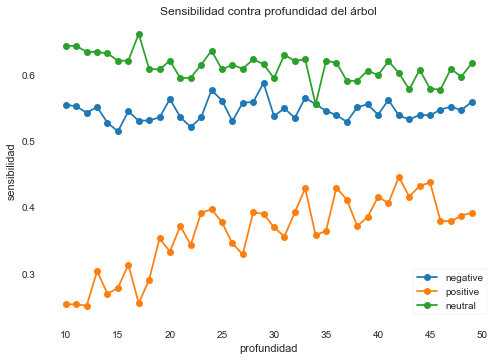

In [23]:
# Graficamos las sensibilidades para cada profundidad
plt.plot(prof, sensibilidades_negative, 'o-', label = "negative")
plt.plot(prof, sensibilidades_positive, 'o-', label = "positive")
plt.plot(prof, sensibilidades_neutral, 'o-', label = "neutral")
plt.xlabel('profundidad')
plt.ylabel('sensibilidad')
plt.title('Sensibilidad contra profundidad del árbol')
plt.legend()
plt.show()

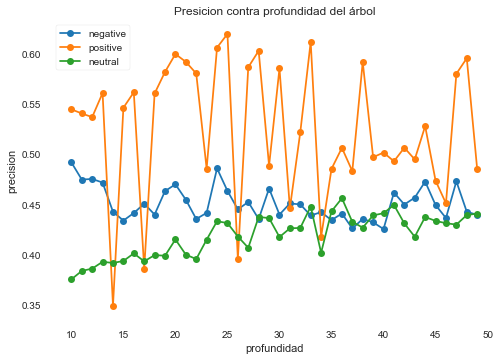

In [24]:
# Graficamos las presiciones para cada profundidad
plt.plot(prof, presiciones_negative, 'o-', label = "negative")
plt.plot(prof, presiciones_positive, 'o-', label = "positive")
plt.plot(prof, presiciones_neutral, 'o-', label = "neutral")
plt.xlabel('profundidad')
plt.ylabel('precision')
plt.title('Presicion contra profundidad del árbol')
plt.legend()
plt.show()

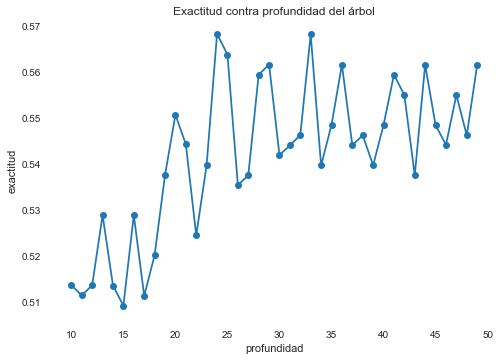

In [25]:
# Graficamos las exactitudes para cada profundidad
plt.plot(prof, exactitudes, 'o-')
plt.xlabel('profundidad')
plt.ylabel('exactitud')
plt.title('Exactitud contra profundidad del árbol')
plt.show()

### Se prueban diferentes tipos de coeficientes (gini y entropia)

In [26]:
indices = ['gini', 'entropy']
sensibilidades_negative = []
sensibilidades_neutral = []
sensibilidades_positive = []
presiciones_negative = []
presiciones_neutral = []
presiciones_positive = []
exactitudes = []
for i in indices:
    clf = DecisionTreeClassifier(criterion = i, max_depth = 40)
    statistics = make_cross_val(5, X_train, y_train, clf)
    sensibilidad = statistics[2]
    presicion = statistics[5]
    exactitud = statistics[6]
    print('Usando el indice de {}'.format(i))
    print('Sensibilidad Positiva: {}'.format(sensibilidad))
    print('Presicion Positiva: {}'.format(presicion))
    print()
    print('Sensibilidad Negativa: {}'.format(statistics[0]))
    print('Presicion Negativa: {}'.format(statistics[3]))
    print()
    print('Sensibilidad Neutra: {}'.format(statistics[1]))
    print('Presicion Neutra: {}'.format(statistics[4]))
    print('Exactitud: {}'.format(exactitud))
    sensibilidades_negative.append(statistics[0])
    sensibilidades_neutral.append(statistics[1])
    sensibilidades_positive.append(statistics[2])
    presiciones_negative.append(statistics[3])
    presiciones_neutral.append(statistics[4])
    presiciones_positive.append(statistics[5])
    exactitudes.append(statistics[6])
    print('--------------------------------//------------------------------')

Usando el indice de gini
Sensibilidad Positiva: 0.3582433894933895
Presicion Positiva: 0.5951384628554308

Sensibilidad Negativa: 0.5671861471861472
Presicion Negativa: 0.46440262843488644

Sensibilidad Neutra: 0.6052759609868044
Presicion Neutra: 0.4393821940333568
Exactitud: 0.5572145246058289
--------------------------------//------------------------------
Usando el indice de entropy
Sensibilidad Positiva: 0.42972826722826724
Presicion Positiva: 0.4989305713443645

Sensibilidad Negativa: 0.6061038961038961
Presicion Negativa: 0.45305642154165904

Sensibilidad Neutra: 0.605617900172117
Presicion Neutra: 0.46594391383865064
Exactitud: 0.554921165790731
--------------------------------//------------------------------


2


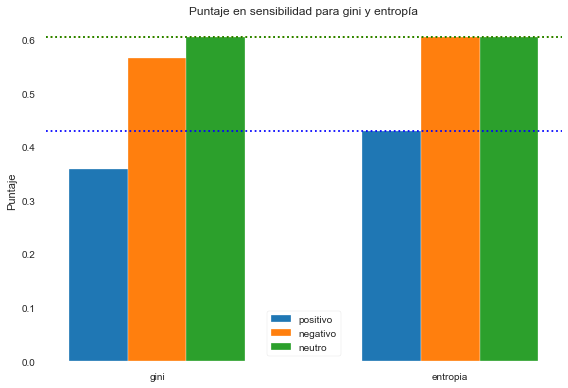

In [27]:
labels = ['gini', 'entropia']
print(len(sensibilidades_positive))
positivo = [sensibilidades_positive[i] for i in range(len(sensibilidades_positive))] 
negativo = [sensibilidades_negative[i] for i in range(len(sensibilidades_positive))] 
neutro = [sensibilidades_neutral[i] for i in range(len(sensibilidades_positive))] 
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x -width, positivo, width, label='positivo')
rects2 = ax.bar(x, negativo, width, label='negativo')
rects3 = ax.bar(x + width, neutro, width, label='neutro')

ax.set_ylabel('Puntaje')
ax.set_title('Puntaje en sensibilidad para gini y entropía')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.axhline(y=positivo[1], color='b', linestyle=':')
plt.axhline(y=negativo[1], color='orange', linestyle=':')
plt.axhline(y=neutro[1], color='g', linestyle=':')

fig.tight_layout()

plt.show()

2


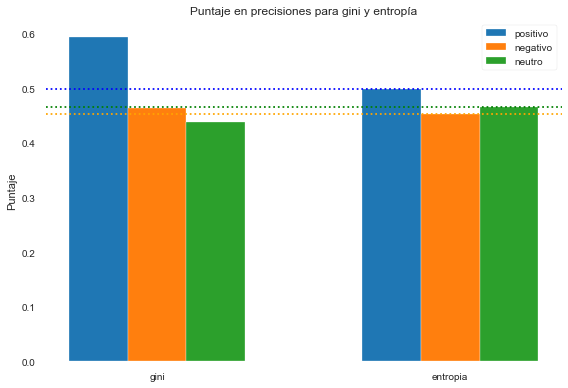

In [28]:
labels = ['gini', 'entropia']
print(len(sensibilidades_positive))
positivo = [presiciones_positive[i] for i in range(len(sensibilidades_positive))] 
negativo = [presiciones_negative[i] for i in range(len(sensibilidades_positive))] 
neutro = [presiciones_neutral[i] for i in range(len(sensibilidades_positive))] 
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x -width, positivo, width, label='positivo')
rects2 = ax.bar(x, negativo, width, label='negativo')
rects3 = ax.bar(x + width, neutro, width, label='neutro')

ax.set_ylabel('Puntaje')
ax.set_title('Puntaje en precisiones para gini y entropía')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.axhline(y=positivo[1], color='b', linestyle=':')
plt.axhline(y=negativo[1], color='orange', linestyle=':')
plt.axhline(y=neutro[1], color='g', linestyle=':')

fig.tight_layout()

plt.show()

2


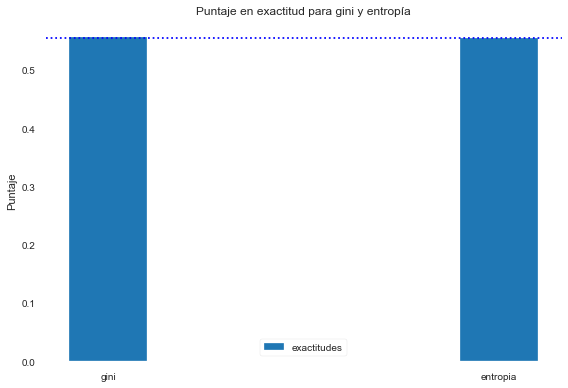

In [29]:
labels = ['gini', 'entropia']
print(len(sensibilidades_positive))
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x, exactitudes, width, label='exactitudes')

ax.set_ylabel('Puntaje')
ax.set_title('Puntaje en exactitud para gini y entropía')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.axhline(y=exactitudes[1], color='b', linestyle=':')

fig.tight_layout()

plt.show()

## Sección 7: Creación del árbol

In [30]:
clf = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 40)
model = clf.fit(X_train,y_train)
y_pred = model.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
print(conf)

[[24  8 28]
 [11  5 11]
 [21  9 33]]


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.43      0.40      0.41        60
     Neutral       0.23      0.19      0.20        27
    Positive       0.46      0.52      0.49        63

    accuracy                           0.41       150
   macro avg       0.37      0.37      0.37       150
weighted avg       0.40      0.41      0.41       150

